## Skill Advisor model using Doc2Vec and K-mean clustering

In [5]:
import glob
import pandas as pd

# Read the cleaned json file generated from wordtovec notebook in dataframe

df = pd.read_json('cleaned_for_embeddings.json', lines=True)

# Get the skills and corresponsing job titiles 
skill_list = df.skill.values.tolist()
job_label = df.job_name.values.tolist()

In [3]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [job_label[i]]) for i, doc in enumerate(skill_list)]


# make doc2vec model,
# dbow_words = 1, dm = 0, see reasoning here:
# https://stackoverflow.com/questions/44011706/what-is-different-between-doc2vec-models-when-the-dbow-words-is-set-to-1-or-0
# try to make document vectors and word vectors more comparable
model1 = Doc2Vec(documents, vector_size=50, window=3, min_count=2, 
                 workers=4, dbow_words=1, dm=0)

In [4]:
# train model
model1.train(documents=documents, total_examples=model1.corpus_count, epochs=50)

In [5]:
# save model
model1.save('doc2vec_kmeans/doc2vec_kmeans')

## PCA and t-SNE conversion

First load up the model if need to

In [1]:
from gensim.models.doc2vec import Doc2Vec
model1 = Doc2Vec.load('doc2vec_kmeans/doc2vec_kmeans')

This part of the code (`tsneconversion` and `cluster_visualization`) is copied over from `wordtovec.ipynb` just to make it easier

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def tsneconversion(model, word, list_names, labels=['Target', 'Related', 'Comparitive']):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    word_labels = [word]
    color_list  = ['red']
    label_list  = [labels[0]]

    # initialize with the query word vector
    word_vector = model[word]
    arrays = np.array([word_vector])
    
    # gets list of most similar words/skills to target word
    close_words = model.wv.most_similar([word_vector])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.get_vector(wrd_score[0])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        label_list.append(labels[1])
        arrays = np.append(arrays, [wrd_vector], axis=0)
    
    # adds the vector for each of the words from list_names to the array
    # used for comparison in visualization
    for wrd in list_names:
        wrd_vector = model.wv.get_vector(wrd)
        word_labels.append(wrd)
        color_list.append('green')
        label_list.append(labels[2])
        arrays = np.append(arrays, [wrd_vector], axis=0)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arrays)
    
    # Sets everything up to plot
    df = pd.DataFrame({'X': [x for x in Y[:, 0]],
                       'Y': [y for y in Y[:, 1]],
                       'skill': word_labels,
                       'color': color_list,
                       'label': label_list})
    
    return (df, Y)

/anaconda3/envs/dataworks-forge/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
def cluster_visualization(df, word, Y, x_lim, y_lim, title_fmt='Visualization for {}'):
    """
    Function contains
    df = dataframe contanining t-SNE X and Y value for the relavent scatter plot
    word = name of the job or skill
    Y = The t-SNE coordinates of all datapoints
    x_lim, y_lim = Plot limit
    """
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    
    # Basic plot
    for color in df.color.unique():
      df_same_color = df[df.color == color]
      label = df_same_color.label.values[0]
      sns.scatterplot(data=df,
                  x="X",
                  y="Y",
                  marker="x",
                  ax=ax,
                  legend=False,
                  color= color,
                  label=label
                )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         ax.text(df["X"][line],
                 df['Y'][line],
                 '  ' + df["skill"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='small',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(18)

    
    #plt.xlim(Y[:, 0].min()-150, Y[:, 0].max()+500)
    #plt.ylim(Y[:, 1].min()-150, Y[:, 1].max()+200)
    
    if x_lim != 0:
        ax.set_xlim(Y[:, 0].min()-x_lim, Y[:, 0].max()+x_lim)
        ax.set_ylim(Y[:, 1].min()-y_lim, Y[:, 1].max()+y_lim)
    
    ax.set_title(title_fmt.format(word.title()))
    #handles, labels = ax.get_legend_handles_labels()
    ax.legend()
    #fig1.savefig("output.png")

In [24]:
# Get job_title vectors

unique_jobs = set(job_label)
job_vectors = []
for job in unique_jobs:
    job_vectors.append(model1[job])

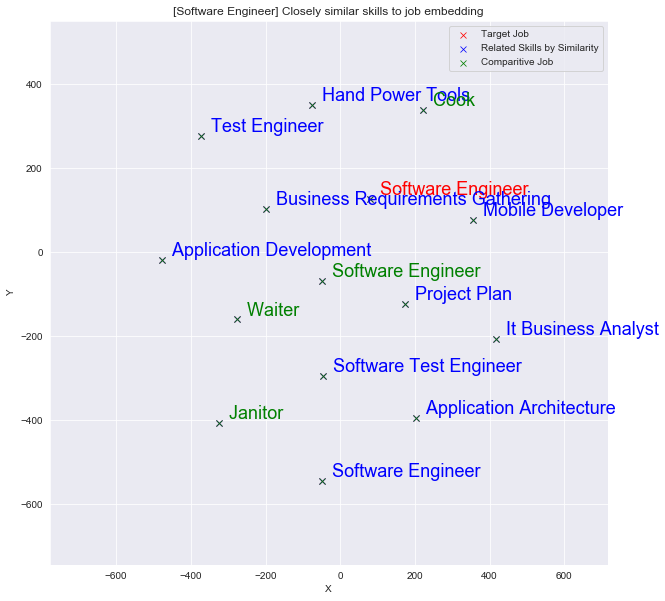

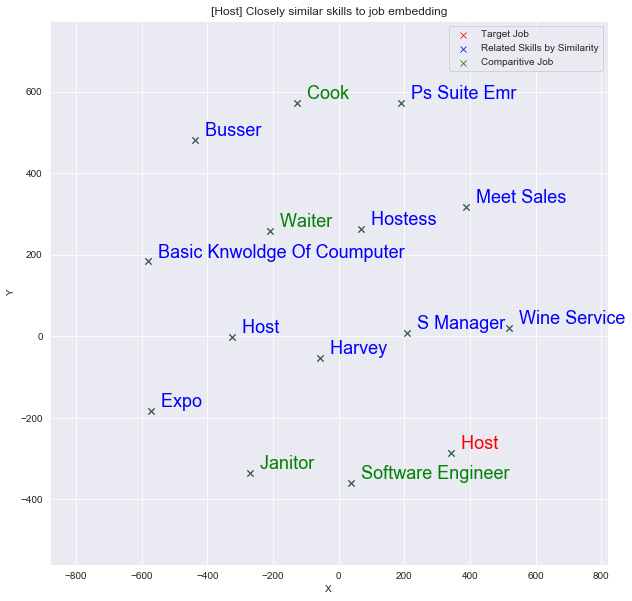

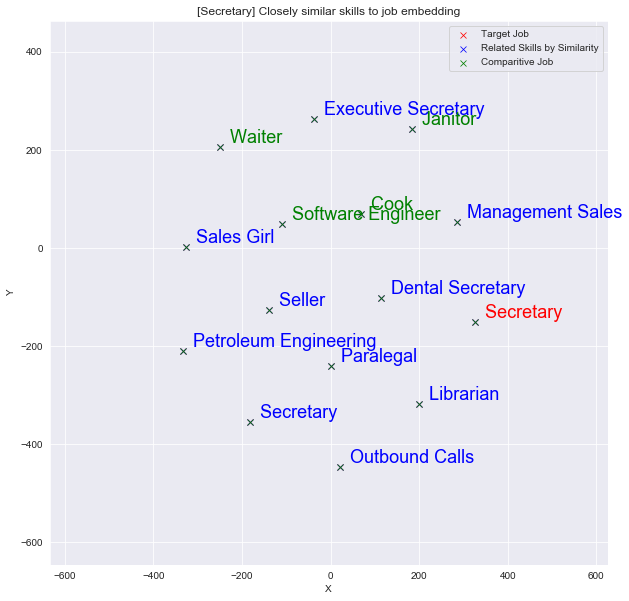

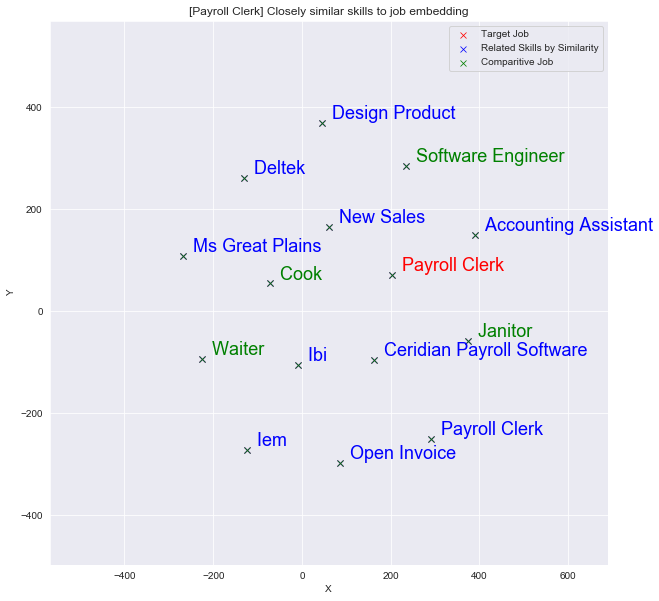

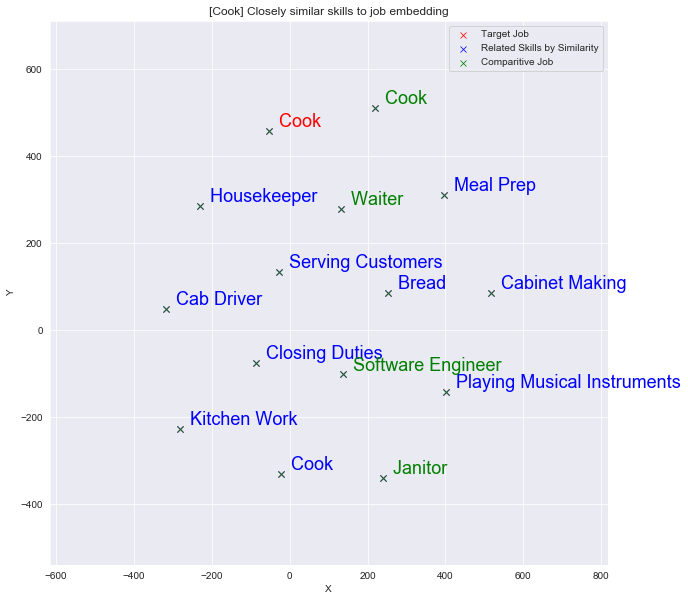

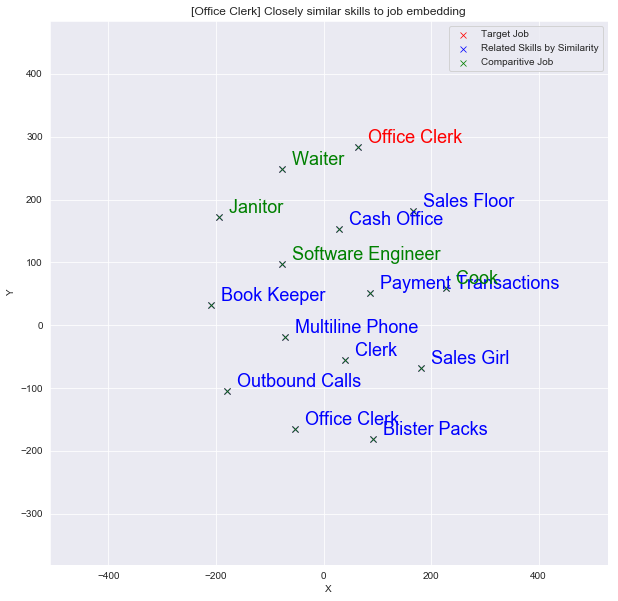

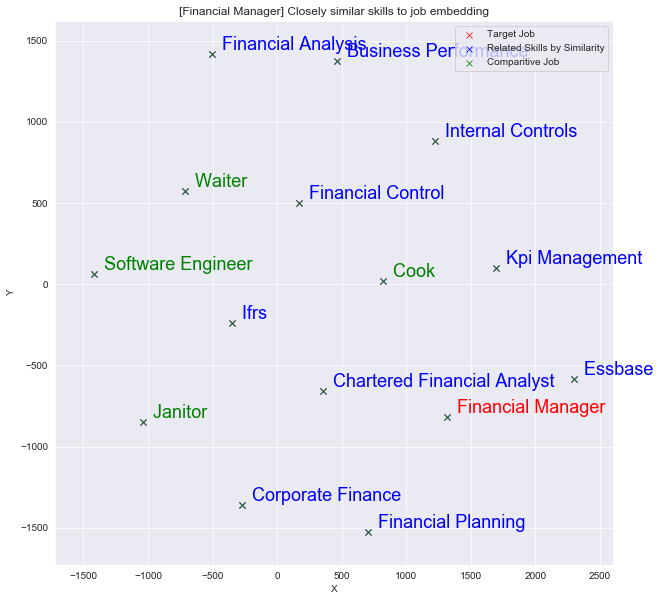

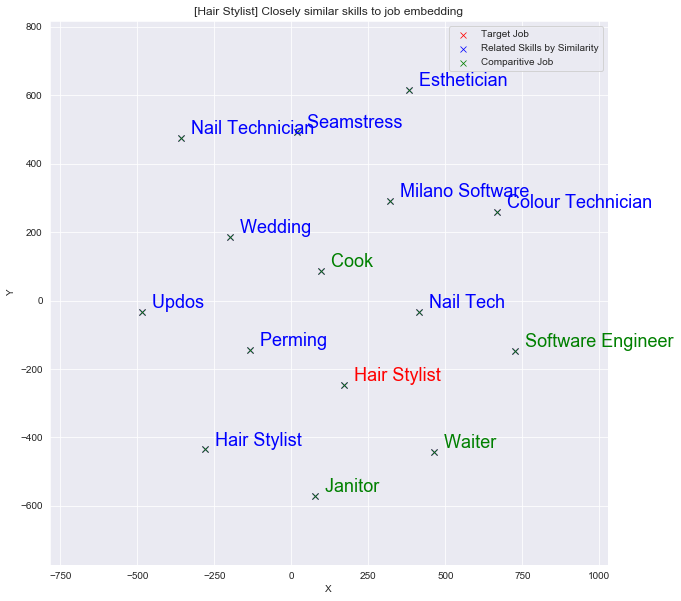

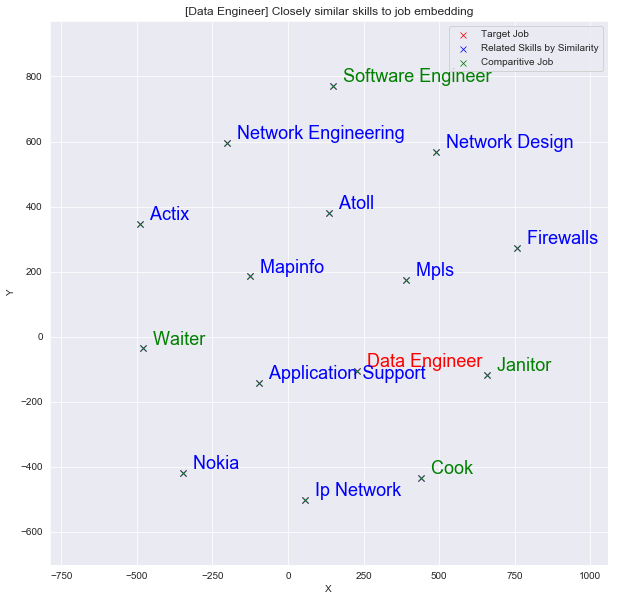

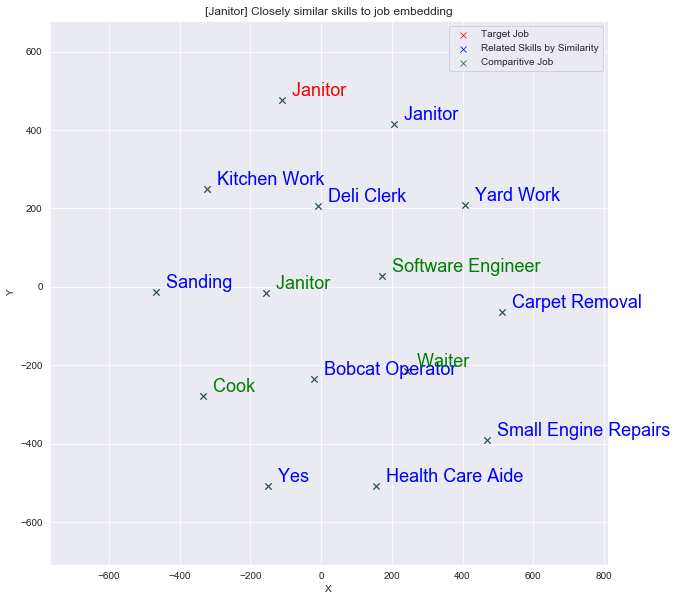

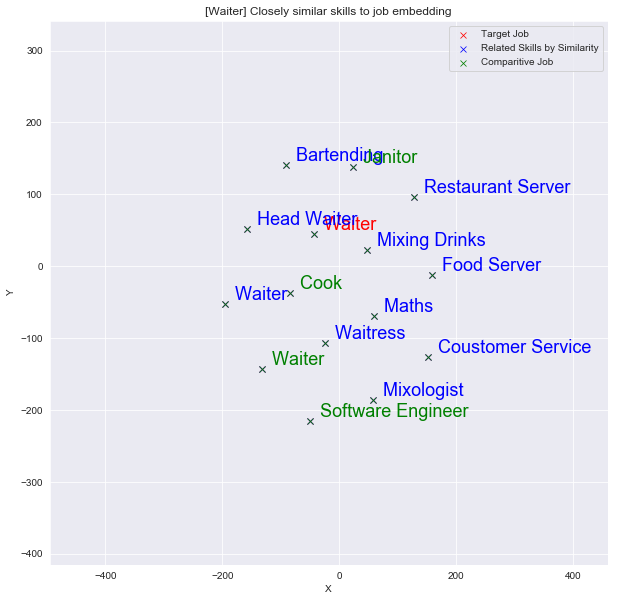

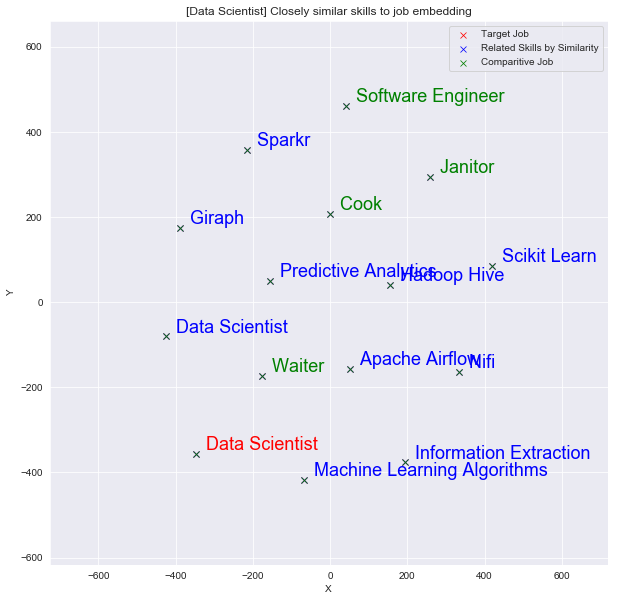

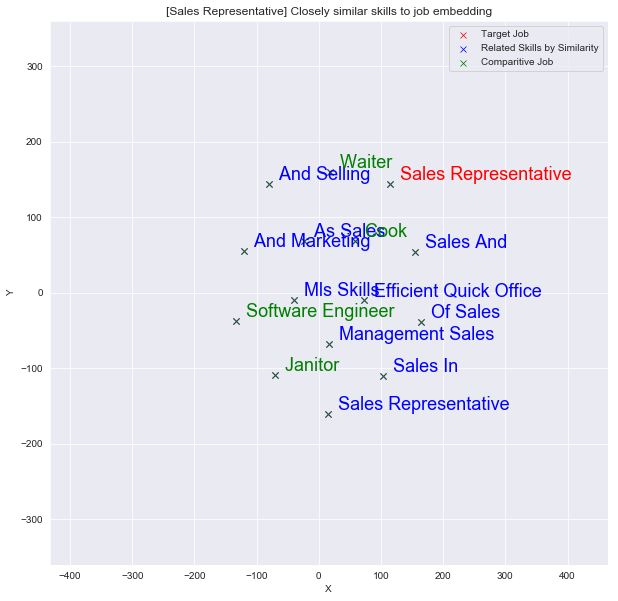

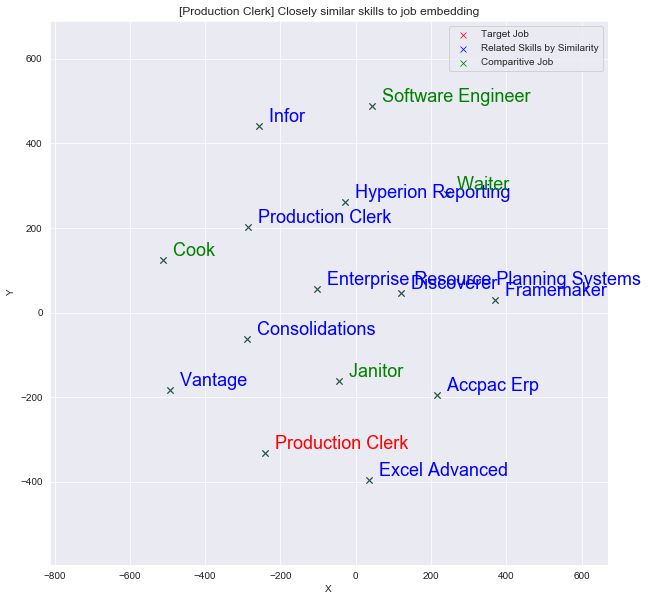

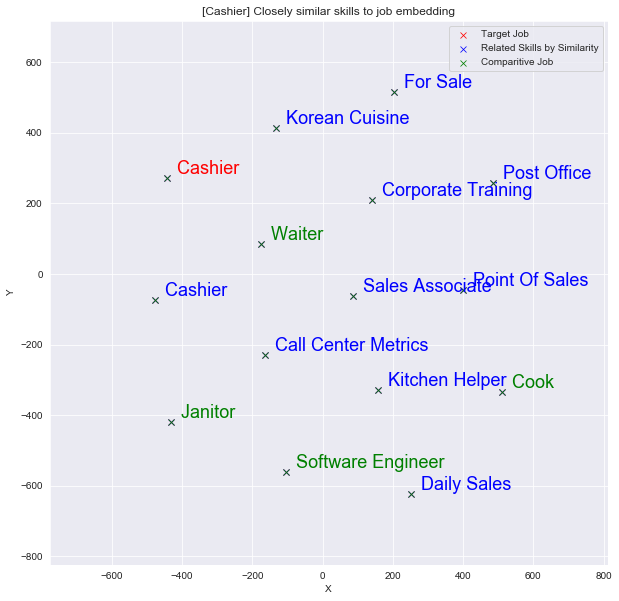

In [26]:
for job in unique_jobs:
  df_tsne, Y = tsneconversion(
    model1,
    job,
    ['cook', 'janitor', 'waiter', 'software engineer'],
    labels=['Target Job', 'Related Skills by Similarity', 'Comparitive Job']
  )
  cluster_visualization(df_tsne, job, Y, 300, 200, title_fmt='[{}] Closely similar skills to job embedding')

In [27]:
# Get skill Vectors

skill_vectors = []
for skill in model1.wv.vocab.keys():
    skill_vectors.append(model1.wv[skill])

In [36]:
# Combine all vectors 

import numpy as np

job_vectors = np.array(job_vectors)
skill_vectors = np.array(skill_vectors)
all_vec = np.concatenate((job_vectors, skill_vectors))
skills_and_jobs = list(unique_jobs) + list(model1.wv.vocab.keys())

# normalize embeddings so its meaning is equal to euclidean distance
# see https://stats.stackexchange.com/questions/299013/cosine-distance-as-similarity-measure-in-kmeans
all_vec = all_vec / np.linalg.norm(all_vec, axis=1)[:, np.newaxis]

In [37]:
all_vec.shape

(13984, 50)

In [44]:
# Run K-means

import nltk
from nltk.cluster import KMeansClusterer

NUM_CLUSTERS = 15
# take the first NUM_CLUSTERS from all_vec since they would
# be the embeddings for jobs
initial_means = list(all_vec[:NUM_CLUSTERS])

kclusterer = KMeansClusterer(
  NUM_CLUSTERS,
  distance=nltk.cluster.util.cosine_distance,
  initial_means=initial_means
)
assigned_clusters = kclusterer.cluster(all_vec, assign_clusters=True)

In [45]:
# For visualization

# Reduces the dimensionality from 300 to 50 dimensions with PCA
#reduc = PCA(n_components=50).fit_transform(all_vec)
# Finds t-SNE coordinates for 2 dimensions
np.set_printoptions(suppress=True)

Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(all_vec)

In [46]:
# Create dataframe with skills and corresponding cluster number and TSNE co-ordinates

df_cluster = pd.DataFrame(
  {
    'skill': skills_and_jobs,
    'cluster': assigned_clusters, 
    'X': Y[:,0],
    'Y': Y[:,1],
    'point': list(all_vec)
  }
)
df_cluster

,skill,cluster,X,Y,point
0,software engineer,12,37.594120,-1.945390,"[0.028872583, 0.26512694, 0.17886874, -0.04159..."
1,host,14,-32.183754,40.109169,"[0.10346785, 0.017610643, -0.02946439, 0.02183..."
2,secretary,12,-9.442631,-21.182949,"[0.10939362, 0.014271175, 0.07705954, -0.02720..."
3,payroll clerk,12,3.431309,-24.983725,"[0.23508988, -0.03349529, 0.060474277, 0.12141..."
4,cook,14,-31.975281,53.285603,"[0.019369949, -0.06340435, -0.1325594, -0.2873..."
5,office clerk,2,-7.633258,-16.733118,"[0.081603125, 0.10707688, -0.026980305, -0.060..."
6,financial manager,6,22.414705,-51.771935,"[0.11924831, -0.0028593296, 0.40428618, -0.027..."
7,hair stylist,14,-30.653183,75.752518,"[0.07682952, 0.035389, -0.16122147, -0.2725716..."
8,data engineer,8,32.622406,43.128460,"[0.093102634, 0.04699782, 0.015116432, -0.0728..."
9,janitor,14,-19.659008,56.094536,"[0.08612218, 0.036761574, 0.10785234, -0.07407..."


In [18]:
job_clusters = df_cluster.loc[:14]
# see clusters for jobs
job_clusters

,skill,cluster,X,Y,point
0,software engineer,12,37.594120,-1.945390,"[0.028872583, 0.26512694, 0.17886874, -0.04159..."
1,host,14,-32.183754,40.109169,"[0.10346785, 0.017610643, -0.02946439, 0.02183..."
2,secretary,12,-9.442631,-21.182949,"[0.10939362, 0.014271175, 0.07705954, -0.02720..."
3,payroll clerk,12,3.431309,-24.983725,"[0.23508988, -0.03349529, 0.060474277, 0.12141..."
4,cook,14,-31.975281,53.285603,"[0.019369949, -0.06340435, -0.1325594, -0.2873..."
5,office clerk,2,-7.633258,-16.733118,"[0.081603125, 0.10707688, -0.026980305, -0.060..."
6,financial manager,6,22.414705,-51.771935,"[0.11924831, -0.0028593296, 0.40428618, -0.027..."
7,hair stylist,14,-30.653183,75.752518,"[0.07682952, 0.035389, -0.16122147, -0.2725716..."
8,data engineer,8,32.622406,43.128460,"[0.093102634, 0.04699782, 0.015116432, -0.0728..."
9,janitor,14,-19.659008,56.094536,"[0.08612218, 0.036761574, 0.10785234, -0.07407..."


In [22]:
from nltk.cluster.util import cosine_distance

def get_closest(df_cluster, point, topn=11):
  closeness = df_cluster.copy()
  closeness['distance'] = closeness['point'].apply(lambda p: cosine_distance(p, point))
  closeness = closeness.sort_values('distance')
  return closeness.head(topn)

In [20]:
df_cluster

,skill,cluster,X,Y,point
0,software engineer,12,37.594120,-1.945390,"[0.028872583, 0.26512694, 0.17886874, -0.04159..."
1,host,14,-32.183754,40.109169,"[0.10346785, 0.017610643, -0.02946439, 0.02183..."
2,secretary,12,-9.442631,-21.182949,"[0.10939362, 0.014271175, 0.07705954, -0.02720..."
3,payroll clerk,12,3.431309,-24.983725,"[0.23508988, -0.03349529, 0.060474277, 0.12141..."
4,cook,14,-31.975281,53.285603,"[0.019369949, -0.06340435, -0.1325594, -0.2873..."
5,office clerk,2,-7.633258,-16.733118,"[0.081603125, 0.10707688, -0.026980305, -0.060..."
6,financial manager,6,22.414705,-51.771935,"[0.11924831, -0.0028593296, 0.40428618, -0.027..."
7,hair stylist,14,-30.653183,75.752518,"[0.07682952, 0.035389, -0.16122147, -0.2725716..."
8,data engineer,8,32.622406,43.128460,"[0.093102634, 0.04699782, 0.015116432, -0.0728..."
9,janitor,14,-19.659008,56.094536,"[0.08612218, 0.036761574, 0.10785234, -0.07407..."


/anaconda3/envs/dataworks-forge/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


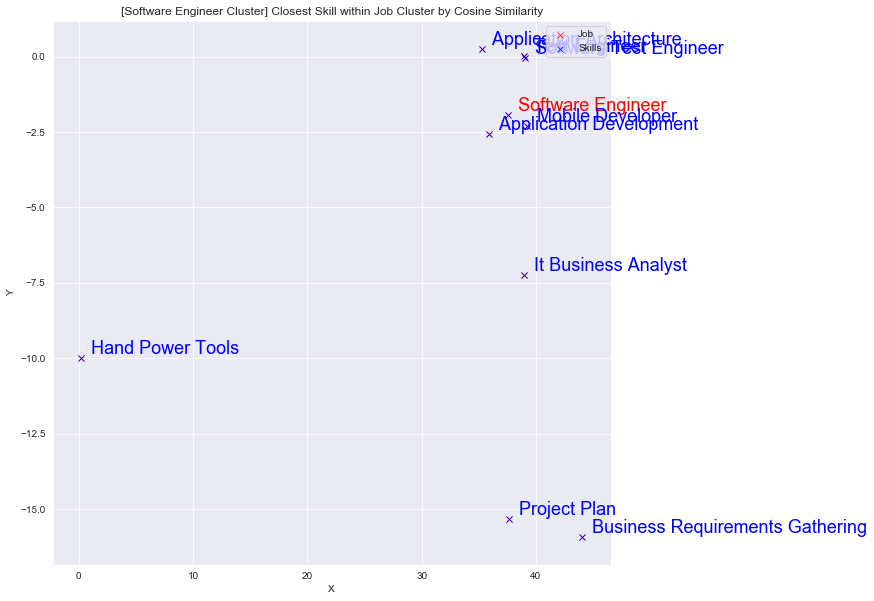

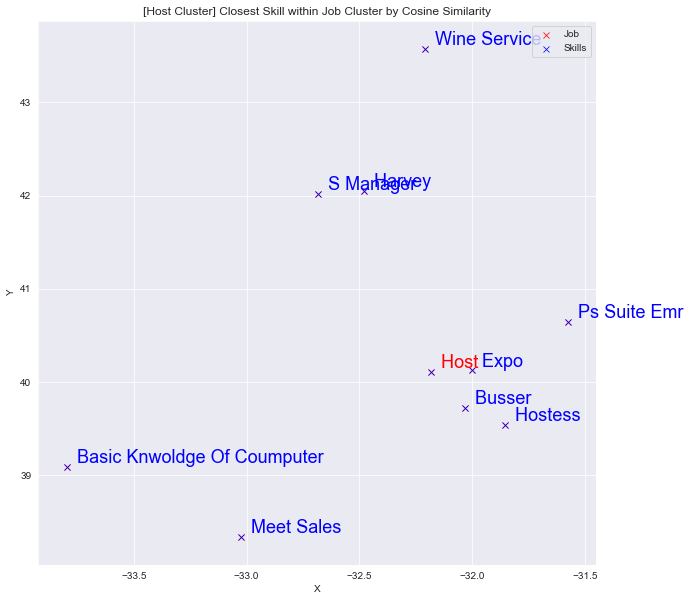

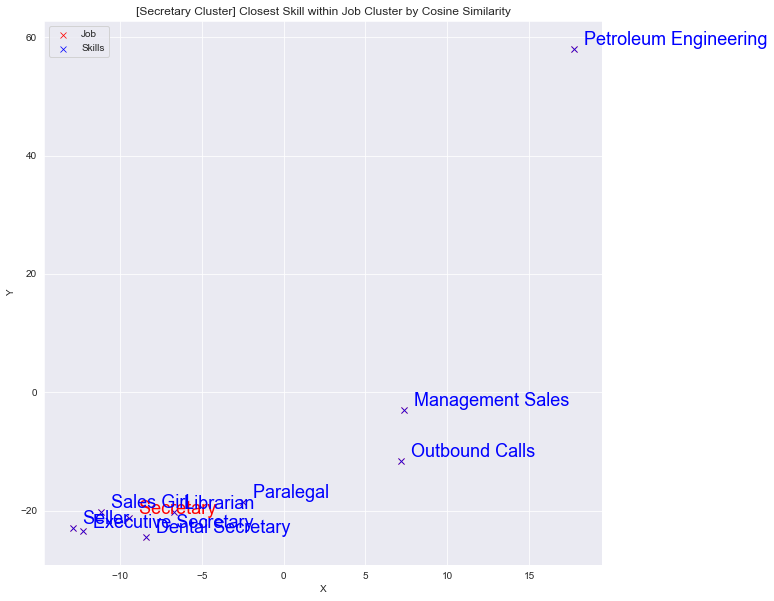

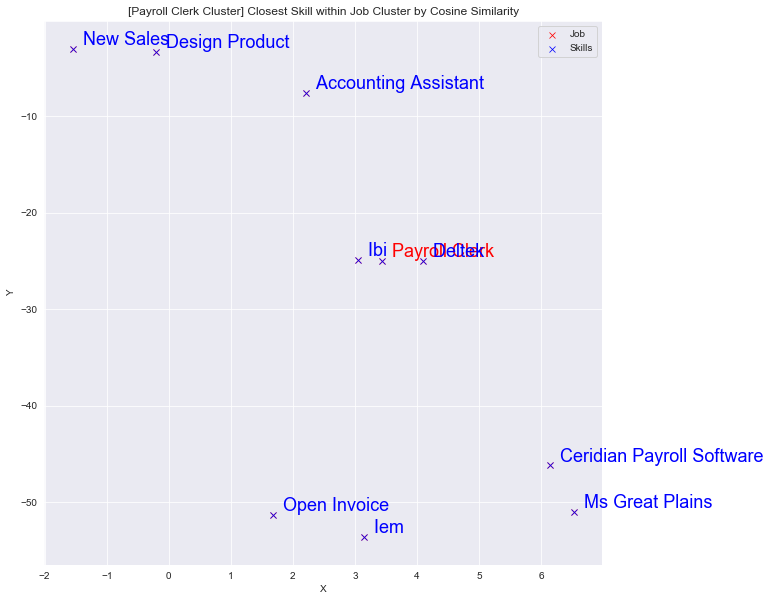

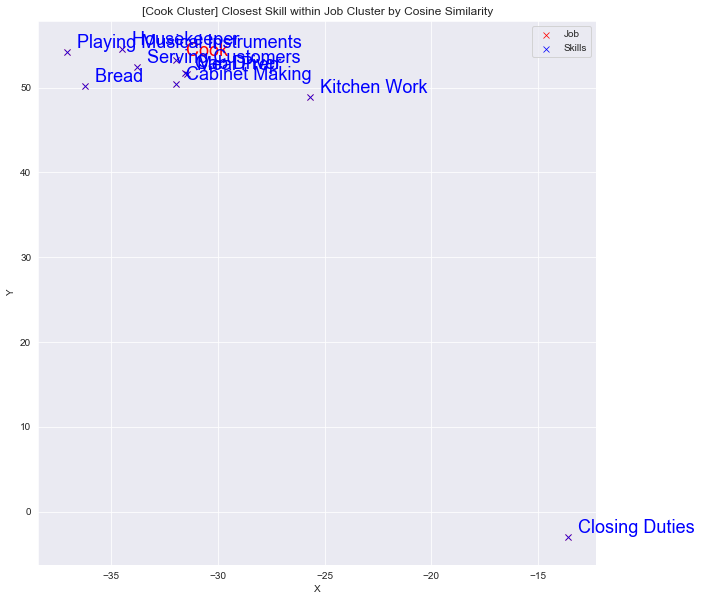

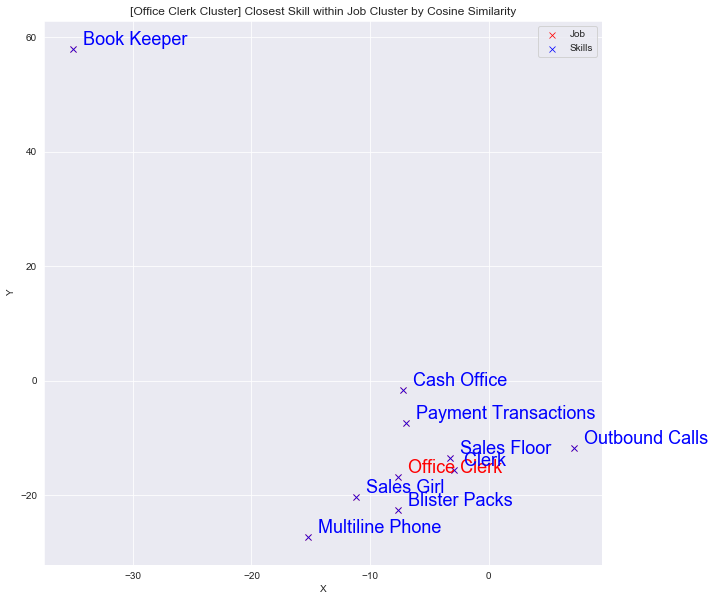

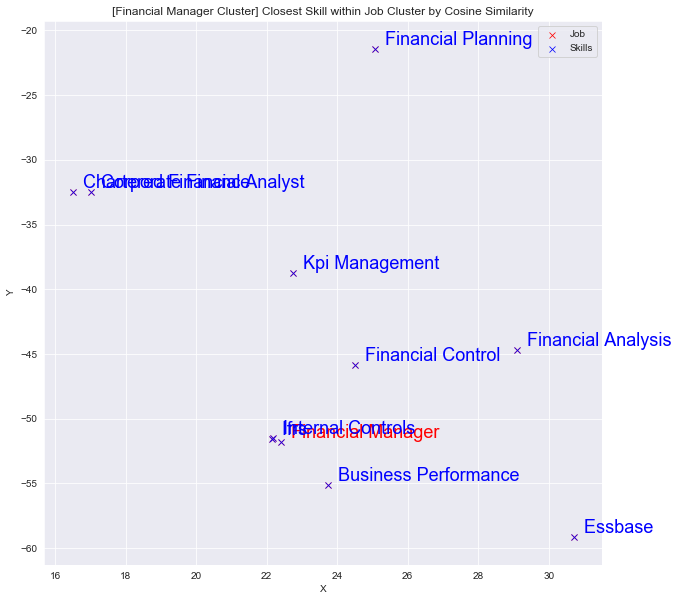

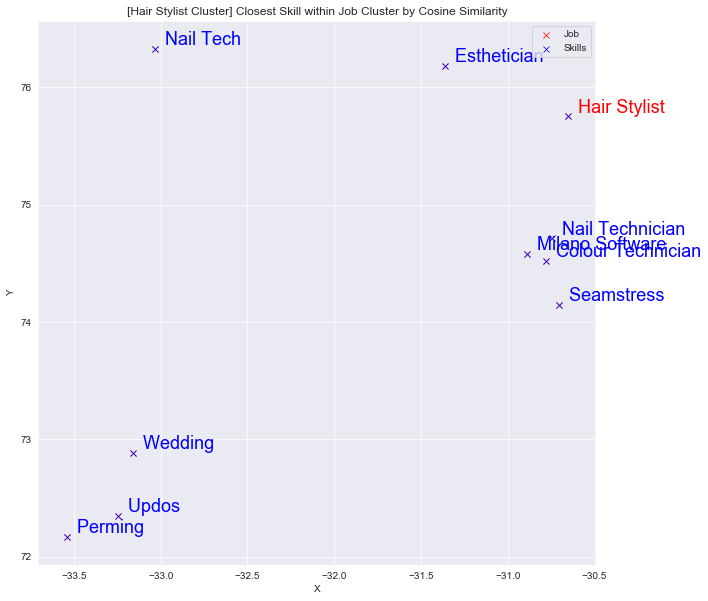

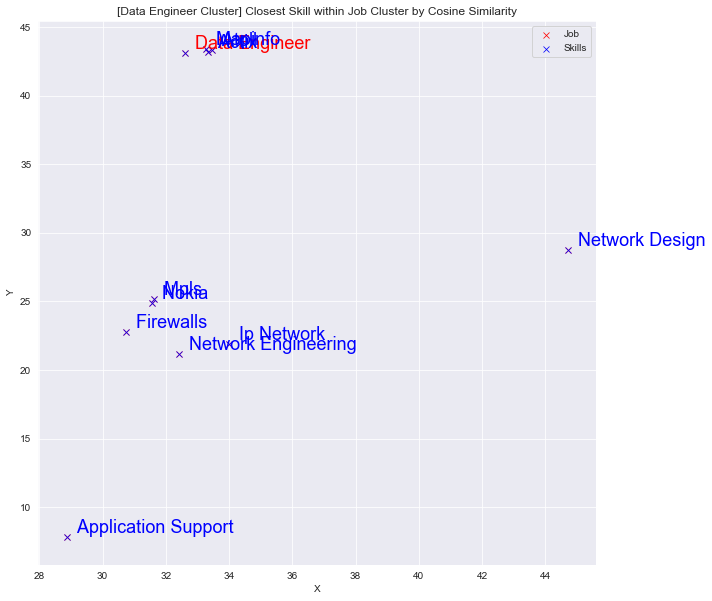

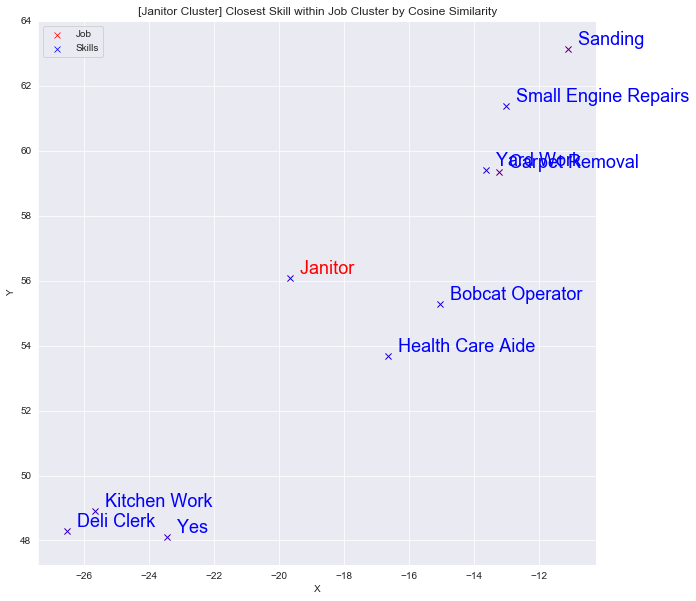

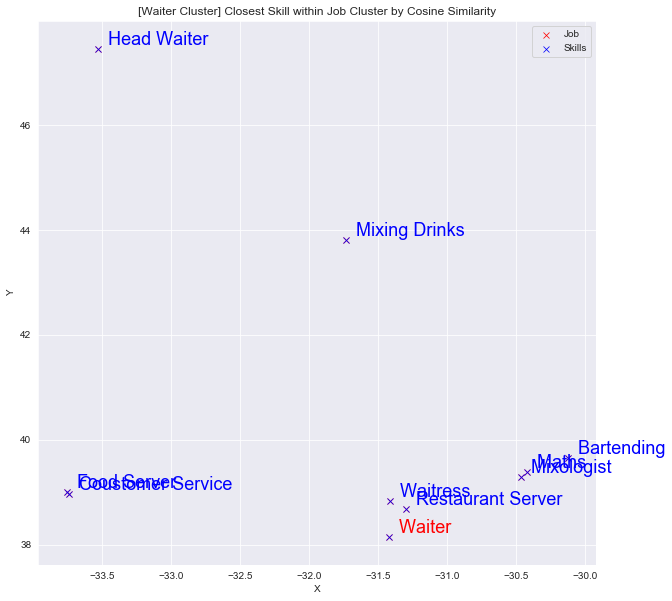

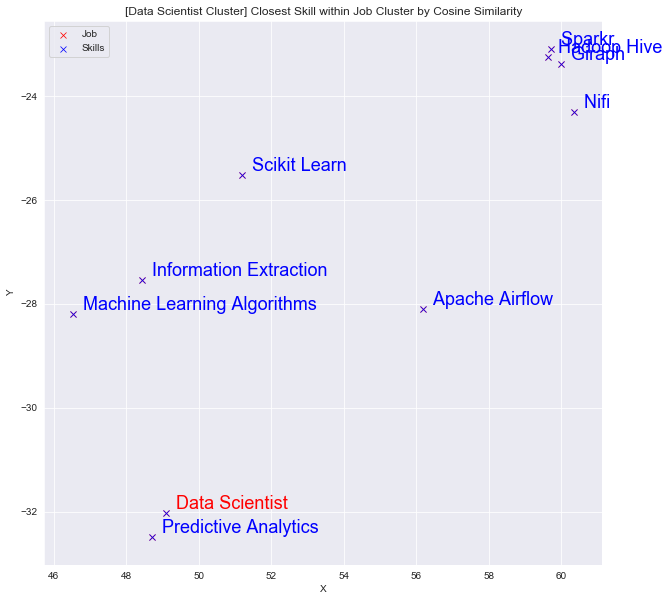

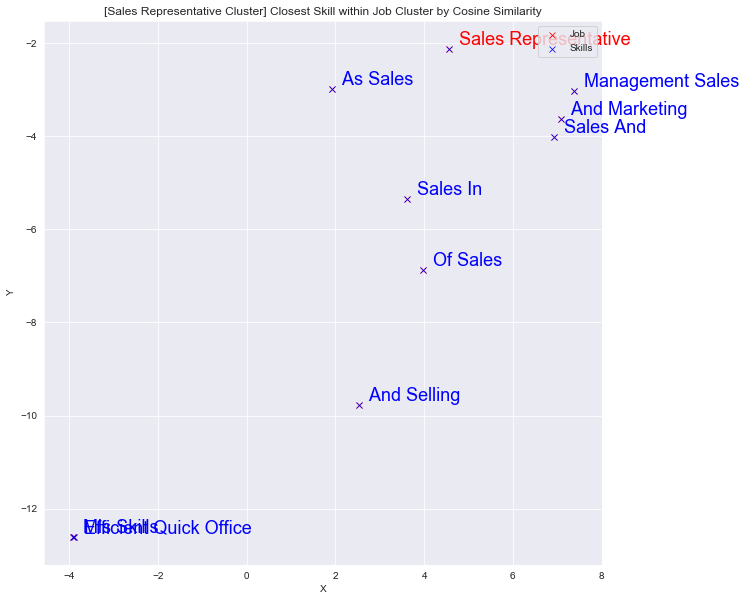

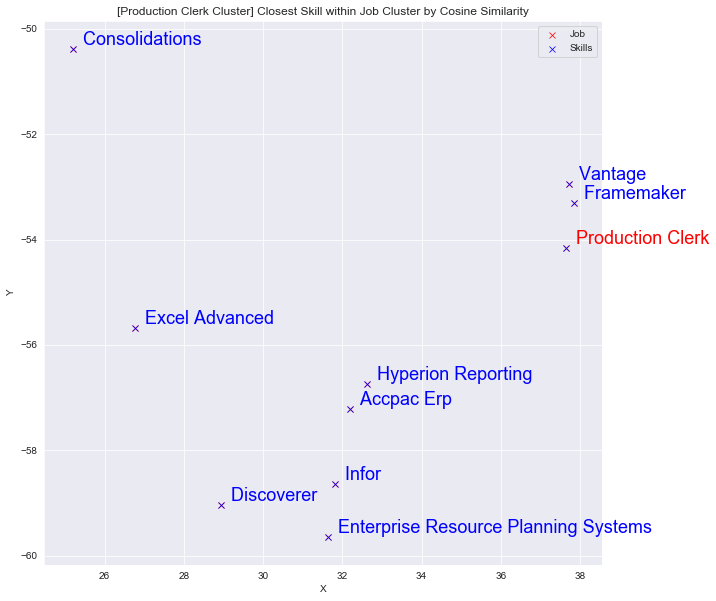

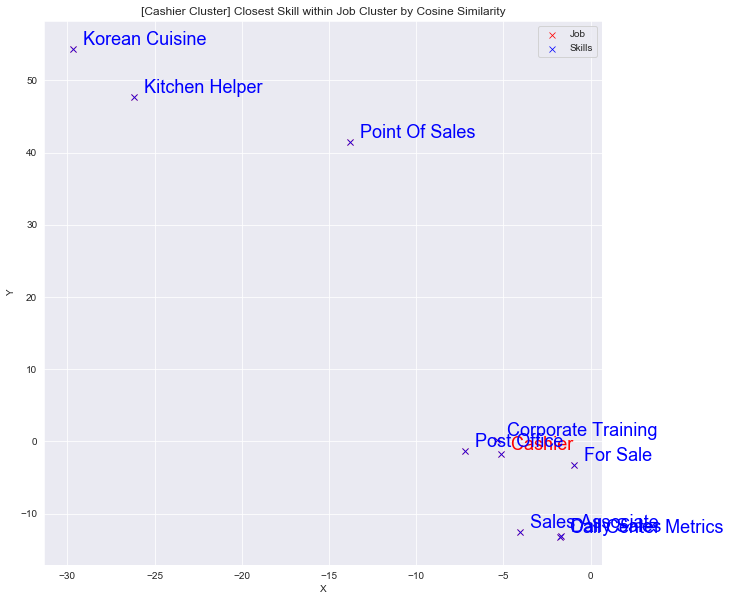

In [47]:
## Plot the cluster of plots with closest skill in the vector space
for idx in range(NUM_CLUSTERS):
  job = df_cluster.loc[[idx]]
  job.loc[:,"color"] = "red"
  cluster_number = job.cluster.values[0]
  df_job_cluster = df_cluster[df_cluster.cluster == cluster_number]

  N_sample = 10
  color = ["blue"] * N_sample
  df_plot = get_closest(df_cluster, job.point.values[0], topn=N_sample + 1)
  job_name = job.skill.values[0]
  df_plot = df_plot[df_plot.skill != job_name]
  df_plot["color"] = color[:len(df_plot)]
  df_final_plot = pd.concat([job, df_plot])
  labels = ['Job'] + (['Skills'] * len(df_plot))
  df_final_plot['label'] = labels
  df_final_plot = df_final_plot.reset_index(drop=True)

  cluster_visualization(df_final_plot, job_name, Y, 0, 0, title_fmt='[{} Cluster] Closest Skill within Job Cluster by Cosine Similarity')

## Silhoutte Analysis

Printing silhoutte score of cluster

In [76]:
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_distances

cluster_points = df_cluster.point.tolist()
cluster_labels = df_cluster.cluster.to_numpy()
silhouette_avg = silhouette_score(cluster_points, cluster_labels, metric='cosine')
'Silhoutte score is %f' % silhouette_avg

'Silhoutte score is 0.123983'

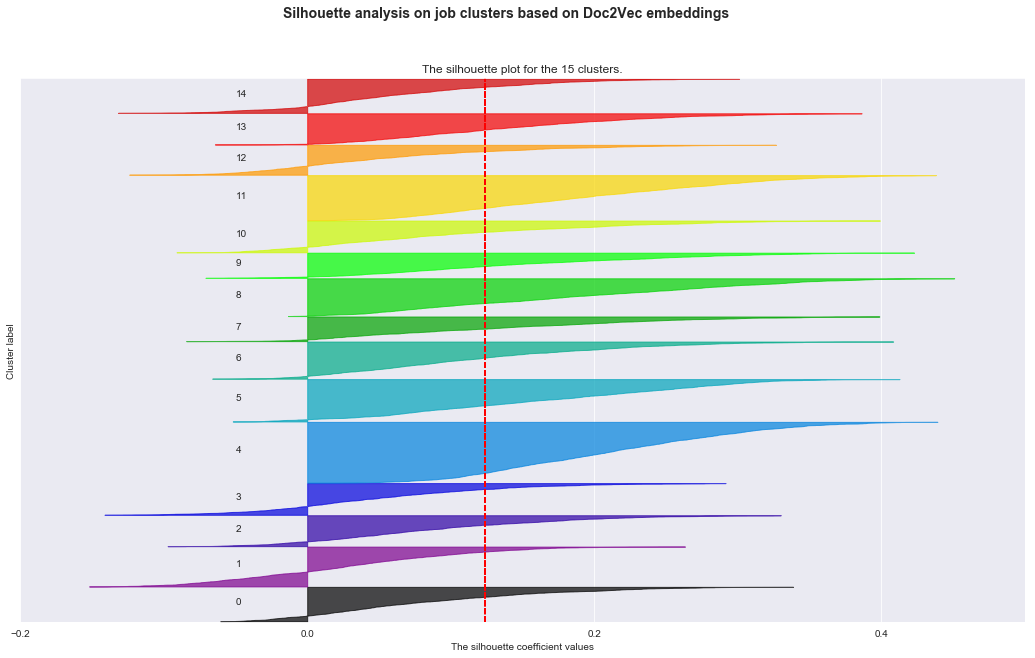

In [100]:
# this code is adapted from
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.metrics import silhouette_samples
from matplotlib import cm

# Create a subplot with 1 row and 2 columns

fig, ax = plt.subplots()
fig.set_size_inches(18, 10)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
ax.set_xlim([-0.2, 0.5])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax.set_ylim([0, len(cluster_points) + (NUM_CLUSTERS + 1) * 10])

# Compute the silhouette scores for each sample
norm_cluster_points = np.linalg.norm(cluster_points, axis=1)
sample_silhouette_values = silhouette_samples(cluster_points, cluster_labels, metric='cosine')

y_lower = 10
for i in range(NUM_CLUSTERS):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    #ith_cluster_silhouette_values = ith_cluster_silhouette_values[:20]
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    #print(ith_cluster_silhouette_values)
    color = cm.nipy_spectral(float(i) / NUM_CLUSTERS)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the 15 clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks(np.arange(-0.2, 0.5, 0.2))
    
    plt.suptitle("Silhouette analysis on job clusters based on Doc2Vec embeddings",
                 fontsize=14, fontweight='bold')